In [1]:
%matplotlib inline
from subprocess import run
import os
from matplotlib import patches, collections
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from cartopy import crs, feature
import xarray as xr
import numpy as np

In [2]:
# Example high resolution (e.g. DECK_ne120) data
# Source: https://web.lcrc.anl.gov/public/e3sm/inputdata/atm/cam/chem/trop_mozart_aero/emis/DECK_ne120/
data_dir = '/mnt/d/Work/Codes/'
edata = xr.open_dataset(data_dir+'cmip6_mam4_bc_a4_surf_2010-2014_c181121.nc')
edata

<xarray.Dataset>
Dimensions:  (lat: 384, lon: 576, time: 72)
Coordinates:
  * lon      (lon) float32 0.0 0.625 1.25 1.875 ... 357.5 358.125 358.75 359.375
  * lat      (lat) float32 -90.0 -89.53003 -89.06005 ... 89.06005 89.53003 90.0
Dimensions without coordinates: time
Data variables:
    ALL      (time, lat, lon) float32 ...
    date     (time) int32 ...
Attributes:
    history:  Thu Oct 18 14:46:43 2018: ncap2 -v -s ALL=AGR+ENE+IND+TRA+RCO+S...
    NCO:      netCDF Operators version 4.7.6 (Homepage = http://nco.sf.net, C...

In [19]:
# Create SCRIP file of the input emission data file
run(f'ncks --rgr infer --rgr scrip={data_dir}grid_dir/384x576_SCRIP.20220216.nc {data_dir}cmip6_mam4_bc_a4_surf_2010-2014_c181121.nc {data_dir}foo.nc'.split(' '), capture_output=True)

CompletedProcess(args=['ncks', '--rgr', 'infer', '--rgr', 'scrip=/mnt/d/Work/Codes/grid_dir/384x576_SCRIP.20220216.nc', '/mnt/d/Work/Codes/cmip6_mam4_bc_a4_surf_2010-2014_c181121.nc', '/mnt/d/Work/Codes/foo.nc'], returncode=0, stdout=b'', stderr=b'')

In [6]:
# Create map file (weight generation) using the SCRIP files
# Different algorithms are applied to check which one works best (for ne30np4)
# Recommended for e3sm: tempest
algo_list = ['bilinear','conserve','nco_con','nco_idw','fv2se_flx','fv2se_stt', 'fv2se_alt']
res_list = [4, 16, 30, 120]
for algo in algo_list:
    run(f'ncremap --alg_typ={algo} --src_grd={data_dir}grid_dir/384x576_SCRIP.20220216.nc --dst_grd={data_dir}grid_dir/ne30np4_scrip.nc -m {data_dir}grid_dir/map_384x576_ne30np4_{algo}.nc'.split(' '), capture_output=True)

In [7]:
# Actual regridding of the file
# Again applying different algo map files
for algo in algo_list:
    run(f'ncremap --map={data_dir}grid_dir/map_384x576_ne30np4_{algo}.nc {data_dir}cmip6_mam4_bc_a4_surf_2010-2014_c181121.nc {data_dir}cmip6_mam4_bc_a4_surf_2010-2014_ne30np4_{algo}_c181121.nc'.split(' '), capture_output=True)

Text(0.5, 1.0, 'original_grid | algo = N/A\n global mean = 2.476779e+09, max = 1.85e+09, min = 0.00e+00')

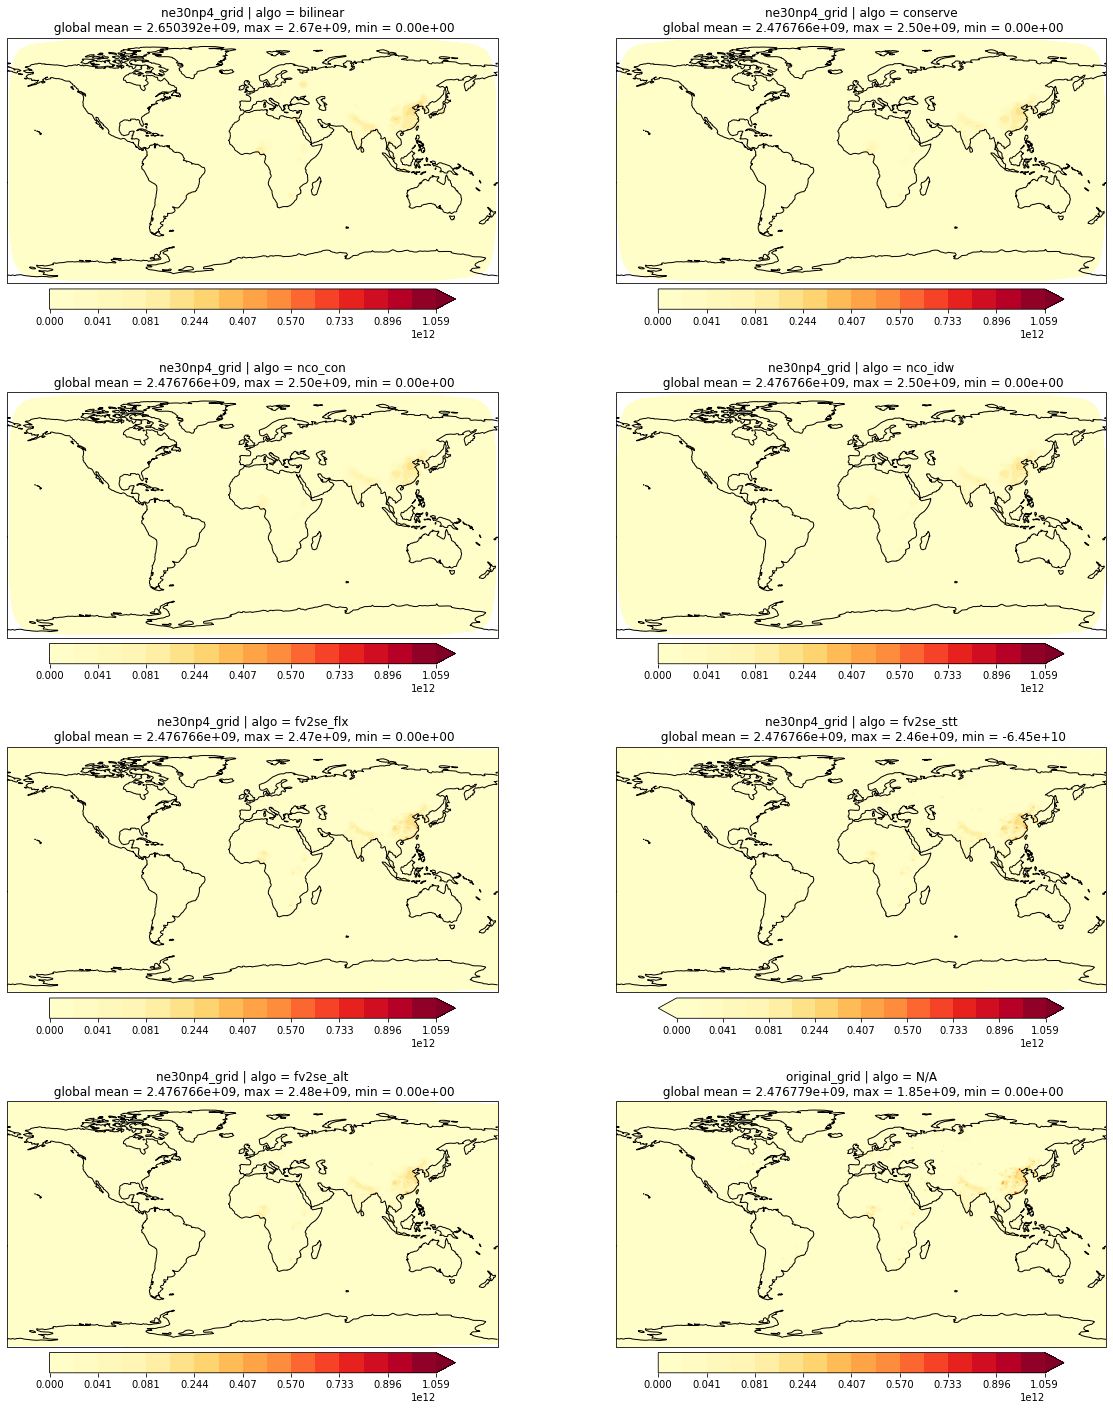

In [99]:
from cartopy.util import add_cyclic_point
from e3sm_map_plot import plot_field, get_area_weights, area_average, get_data
algo_list = ['bilinear','conserve','nco_con','nco_idw','fv2se_flx','fv2se_stt', 'fv2se_alt']
figure = plt.figure(figsize=(20, 25))
i=1
for algo in algo_list:
    data_orig = xr.open_dataset(data_dir+'cmip6_mam4_bc_a4_surf_2010-2014_ne30np4_'+algo+'_c181121.nc')
    data=get_data(data_orig,'ALL')
    wgts = get_area_weights(data_orig)
    avg=area_average(data.mean(dim='time'),wgts).values
    mx = data.mean(dim='time').mean().values
    mn = data.mean(dim='time').min().values
    axes = figure.add_subplot(420+i, projection=crs.PlateCarree())
    plot_field(data_orig,'ALL')
    plt.title('ne30np4_grid | algo = '+algo+'\n global mean = '+str(format(avg, '.6e')+', max = '+str(format(mx, '.2e'))+', min = '+str(format(mn, '.2e'))))
    i=i+1
data_orig = xr.open_dataset(data_dir+'cmip6_mam4_bc_a4_surf_2010-2014_c181121.nc')
data=get_data(data_orig,'ALL')
wgts = get_area_weights(data_orig)
avg=area_average(data.mean(dim='time'),wgts).values
mx = data.mean(dim='time').mean().values
mn = data.mean(dim='time').min().values
axes = figure.add_subplot(428, projection=crs.PlateCarree())
plot_field(data_orig,'ALL')
plt.title('original_grid | algo = N/A\n global mean = '+str(format(avg, '.6e')+', max = '+str(format(mx, '.2e'))+', min = '+str(format(mn, '.2e'))))

In [36]:
import pandas as pd
time = data.time
df = pd.DataFrame()
for algo in algo_list:
    data_orig = xr.open_dataset(data_dir+'cmip6_mam4_bc_a4_surf_2010-2014_ne30np4_'+algo+'_c181121.nc')
    data=get_data(data_orig,'ALL')
    wgts = get_area_weights(data_orig)
    ts=[]
    for i in range(len(data)):
        ts.append(area_average(data[i],wgts).values)
    df[algo] = ts
data_orig = xr.open_dataset(data_dir+'cmip6_mam4_bc_a4_surf_2010-2014_c181121.nc')
data=get_data(data_orig,'ALL')
wgts = get_area_weights(data_orig)
ts=[]
for i in range(len(data)):
    ts.append(area_average(data[i],wgts).values)
df['original'] = ts
df

,bilinear,conserve,nco_con,nco_idw,fv2se_flx,fv2se_stt,fv2se_alt,original
0,2963176169.6655493,2792436897.78527,2792436897.78527,2792436897.78527,2792436898.02967,2792436898.7510686,2792436898.1507525,2792454000.0
1,2807968467.006277,2640288203.306787,2640288203.3067875,2640288203.3067875,2640288206.747423,2640288204.8967743,2640288207.7334056,2640304000.0
2,2625343469.663133,2457376567.0626144,2457376567.0626144,2457376567.0626144,2457376570.462248,2457376566.5538373,2457376567.408939,2457390300.0
3,2471652186.0374956,2315083241.8247433,2315083241.8247437,2315083241.8247437,2315083246.163967,2315083243.787454,2315083247.0649343,2315095600.0
4,2430056252.1551476,2273380867.3154035,2273380867.3154035,2273380867.3154035,2273380877.0640893,2273380877.448069,2273380876.6146774,2273392600.0
...,...,...,...,...,...,...,...,...
67,2518000360.991867,2343368084.005233,2343368084.0052333,2343368084.0052333,2343368081.7613225,2343368083.351808,2343368083.113916,2343379700.0
68,2503720651.5173197,2331873710.533222,2331873710.533223,2331873710.533223,2331873713.7297993,2331873714.7142315,2331873716.217632,2331885300.0
69,2571564640.8122215,2395347252.8193655,2395347252.819366,2395347252.819366,2395347249.474697,2395347251.4739795,2395347250.8407707,2395359700.0
70,2721864632.0257144,2539182959.1504993,2539182959.1505003,2539182959.1505003,2539182960.3466396,2539182958.702796,2539182960.7552886,2539197200.0


Text(0.5, 1.0, 'Relative difference from original global means')

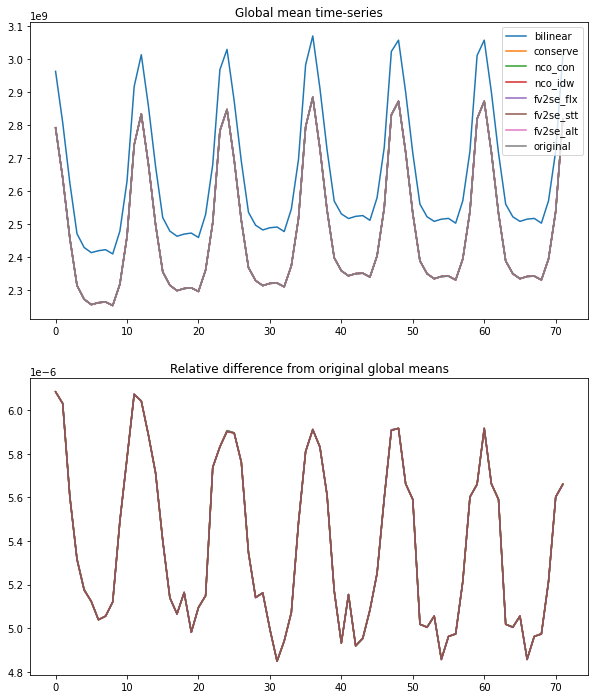

In [91]:
# Relative difference in global means
axes = plt.subplot2grid((2,1),(0,0))
df.astype(float).plot(ax=axes,figsize=(10, 12))
plt.title('Global mean time-series')
axes = plt.subplot2grid((2,1),(1,0))
for algo in algo_list[1:]:
    ((df['original']-df[algo])/df[algo]).astype(float).plot(ax=axes,figsize=(10, 12),label=algo)
plt.title('Relative difference from original global means')

In [94]:
# Best option: fv2se_flx
# What about looking at ne120np4?
algo_list = ['fv2se_flx']
for algo in algo_list:
    run(f'ncremap --alg_typ={algo} --src_grd={data_dir}grid_dir/384x576_SCRIP.20220216.nc --dst_grd={data_dir}grid_dir/ne120np4_scrip.nc -m {data_dir}grid_dir/map_384x576_ne120np4_{algo}.nc'.split(' '), capture_output=True)
for algo in algo_list:
    run(f'ncremap --map={data_dir}grid_dir/map_384x576_ne120np4_{algo}.nc {data_dir}cmip6_mam4_bc_a4_surf_2010-2014_c181121.nc {data_dir}cmip6_mam4_bc_a4_surf_2010-2014_ne120np4_{algo}_c181121.nc'.split(' '), capture_output=True)

Text(0.5, 1.0, 'original_grid | algo = N/A\n global mean = 2.476779e+09, max = 1.85e+09, min = 0.00e+00')

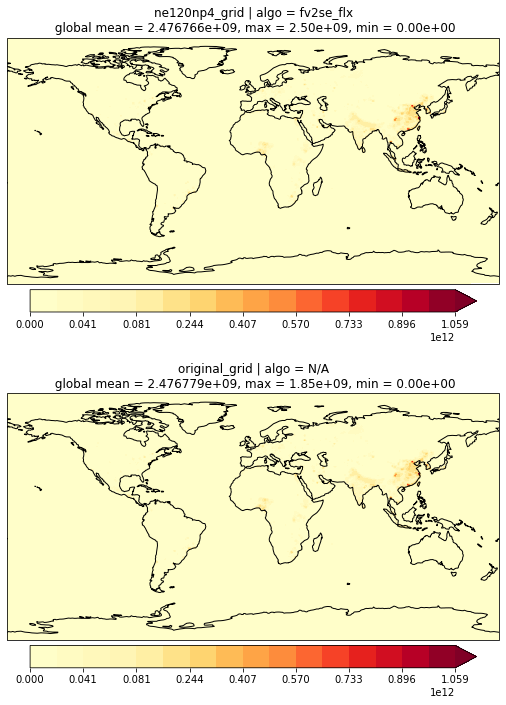

In [102]:
algo_list = ['fv2se_flx']
figure = plt.figure(figsize=(10, 12))
i=1
for algo in algo_list:
    data_orig = xr.open_dataset(data_dir+'cmip6_mam4_bc_a4_surf_2010-2014_ne120np4_'+algo+'_c181121.nc')
    data=get_data(data_orig,'ALL')
    wgts = get_area_weights(data_orig)
    avg=area_average(data.mean(dim='time'),wgts).values
    mx = data.mean(dim='time').mean().values
    mn = data.mean(dim='time').min().values
    axes = figure.add_subplot(210+i, projection=crs.PlateCarree())
    plot_field(data_orig,'ALL')
    plt.title('ne120np4_grid | algo = '+algo+'\n global mean = '+str(format(avg, '.6e')+', max = '+str(format(mx, '.2e'))+', min = '+str(format(mn, '.2e'))))
    i=i+1
data_orig = xr.open_dataset(data_dir+'cmip6_mam4_bc_a4_surf_2010-2014_c181121.nc')
data=get_data(data_orig,'ALL')
wgts = get_area_weights(data_orig)
avg=area_average(data.mean(dim='time'),wgts).values
mx = data.mean(dim='time').mean().values
mn = data.mean(dim='time').min().values
axes = figure.add_subplot(212, projection=crs.PlateCarree())
plot_field(data_orig,'ALL')
plt.title('original_grid | algo = N/A\n global mean = '+str(format(avg, '.6e')+', max = '+str(format(mx, '.2e'))+', min = '+str(format(mn, '.2e'))))

In [104]:
# The maximum doesn't really change!
# What about using the pentagon file?
algo_list = ['nco_idw'] # fv2se algo doesn't work for pentagon
for algo in algo_list:
    run(f'ncremap --alg_typ={algo} --src_grd={data_dir}grid_dir/384x576_SCRIP.20220216.nc --dst_grd={data_dir}grids/ne30np4_pentagons.20190501.nc -m {data_dir}grid_dir/map_384x576_ne30np4_pentagons_{algo}.nc'.split(' '), capture_output=True)
for algo in algo_list:
    run(f'ncremap --map={data_dir}grid_dir/map_384x576_ne30np4_pentagons_{algo}.nc {data_dir}cmip6_mam4_bc_a4_surf_2010-2014_c181121.nc {data_dir}cmip6_mam4_bc_a4_surf_2010-2014_ne30np4_pentagon_{algo}_c181121.nc'.split(' '), capture_output=True)

original:  (72, 384, 576)
ne30np4:  (72, 48602)
ne120np4:  (72, 777602)
ne30np4_pentagon:  (72, 48602)


Text(0.5, 1.0, 'ne30np4_pentagon_grid | algo = nco_idw\n global mean = 2.476766e+09, max = 2.47e+09, min = 0.00e+00')

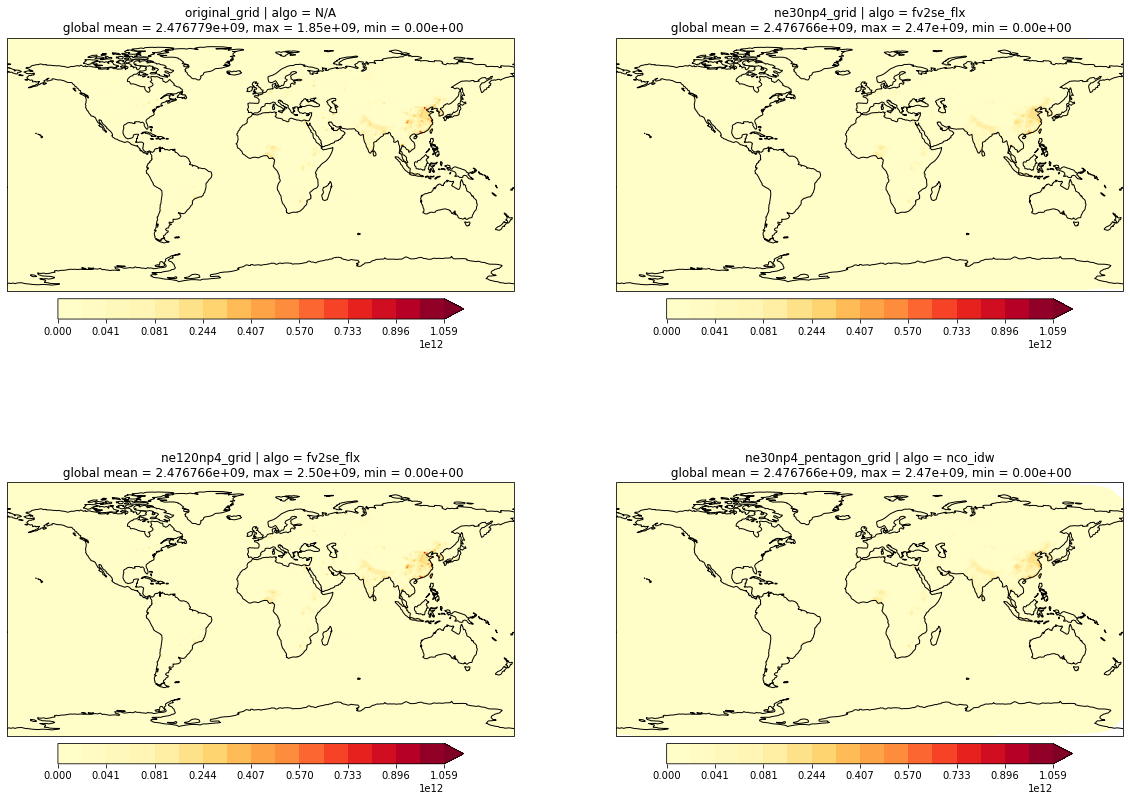

In [123]:
# The pentagon file and the fv2se_flx file produces the same result
figure = plt.figure(figsize=(20, 15))
###############
data_orig = xr.open_dataset(data_dir+'cmip6_mam4_bc_a4_surf_2010-2014_c181121.nc')
data=get_data(data_orig,'ALL')
print('original: ',data.shape)
wgts = get_area_weights(data_orig)
avg=area_average(data.mean(dim='time'),wgts).values
mx = data.mean(dim='time').mean().values
mn = data.mean(dim='time').min().values
axes = figure.add_subplot(221, projection=crs.PlateCarree())
plot_field(data_orig,'ALL')
plt.title('original_grid | algo = N/A\n global mean = '+str(format(avg, '.6e')+', max = '+str(format(mx, '.2e'))+', min = '+str(format(mn, '.2e'))))
###############
data_orig = xr.open_dataset(data_dir+'cmip6_mam4_bc_a4_surf_2010-2014_ne30np4_fv2se_flx_c181121.nc')
data=get_data(data_orig,'ALL')
print('ne30np4: ',data.shape)
wgts = get_area_weights(data_orig)
avg=area_average(data.mean(dim='time'),wgts).values
mx = data.mean(dim='time').mean().values
mn = data.mean(dim='time').min().values
axes = figure.add_subplot(222, projection=crs.PlateCarree())
plot_field(data_orig,'ALL')
plt.title('ne30np4_grid | algo = fv2se_flx\n global mean = '+str(format(avg, '.6e')+', max = '+str(format(mx, '.2e'))+', min = '+str(format(mn, '.2e'))))
###############
data_orig = xr.open_dataset(data_dir+'cmip6_mam4_bc_a4_surf_2010-2014_ne120np4_fv2se_flx_c181121.nc')
data=get_data(data_orig,'ALL')
print('ne120np4: ',data.shape)
wgts = get_area_weights(data_orig)
avg=area_average(data.mean(dim='time'),wgts).values
mx = data.mean(dim='time').mean().values
mn = data.mean(dim='time').min().values
axes = figure.add_subplot(223, projection=crs.PlateCarree())
plot_field(data_orig,'ALL')
plt.title('ne120np4_grid | algo = fv2se_flx\n global mean = '+str(format(avg, '.6e')+', max = '+str(format(mx, '.2e'))+', min = '+str(format(mn, '.2e'))))
###############
data_orig = xr.open_dataset(data_dir+'cmip6_mam4_bc_a4_surf_2010-2014_ne30np4_pentagon_nco_idw_c181121.nc')
data=get_data(data_orig,'ALL')
print('ne30np4_pentagon: ',data.shape)
wgts = get_area_weights(data_orig)
avg=area_average(data.mean(dim='time'),wgts).values
mx = data.mean(dim='time').mean().values
mn = data.mean(dim='time').min().values
axes = figure.add_subplot(224, projection=crs.PlateCarree())
plot_field(data_orig,'ALL')
plt.title('ne30np4_pentagon_grid | algo = nco_idw\n global mean = '+str(format(avg, '.6e')+', max = '+str(format(mx, '.2e'))+', min = '+str(format(mn, '.2e'))))
